In [93]:
# This code splits the given dataset to test-train files.
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import scienceplots
#import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from pathlib import Path
import os

# Apply the default theme
#sns.set_theme()
#sns.set_style('white')
#sns.set_context("paper", font_scale = 2)
#plt.style.use(['science','no-latex'])
print('Pandas v', pd.__version__)

Pandas v 1.3.5


# Configurations

In [94]:
# Configurations 
#latex_dir = Path(r"C:\Users\3057550\OneDrive - Queen's University Belfast\ECIT\Research\AI_Cybersecurity\Teams Files\Papers\In preparation\NLP for SQLi detection\latex\hybrid_nlp_journal")
#latex_dir = Path(r"C:\Users\kasim\OneDrive - Queen's University Belfast\ECIT\Research\AI_Cybersecurity\Teams Files\Papers\In preparation\NLP for SQLi detection\latex\hybrid_nlp_journal")
latex_dir = Path(r'C:\Users\kasim\Documents\GitHub\hybrid_nlp_journal')
SAVE_OUTPUTS = False

In [95]:
# Notes about result files:
# 'results_230214_205321.pkl' # classical ML - Dataset: Train Kaggle, Test Kaggle
# 'results_230214_210527.pkl' # classical ML - Dataset: Train Harika, Test Harika
# 'results_230214_211201.pkl' # classical ML- Dataset: Train: Harika.train, Test: Kaggle.test

# 'results_230214_205100.pkl' # bert - Dataset: Train Kaggle, Test Kaggle
# 'results_230309_112627.pkl' # bert- Dataset: Train Harika, Test Harika
# 'results_230214_193603.pkl' # bert- Dataset: Train: Harika.train, Test: Kaggle.test
main_folder = Path('../')


# results_file = main_folder / 'results_230214_205321.pkl' # classical ML
#results_file = main_folder / 'results' / 'results_1680188240.csv' # temp - all
#results_file = main_folder / 'results' / 'results_230331_152406.csv' # temp - all
results_file = main_folder / 'results' / 'results_230410_165455.csv' # temp - all
#results_file_bert = main_folder / 'results_230214_205100.pkl' # bert
print(results_file.is_file())
#print(results_file_bert.is_file())

True


In [96]:
methods={}

methods['classic_ml'] = ['naive_bayes', 'xgboost', 'svm']
methods['ensemble'] = ['ensemble_1', 'ensemble_2',
       'ensemble_3', 'ensemble_4']
methods['transformer'] = ['bert_en_uncased_L-12_H-768_A-12',
       'bert_en_cased_L-12_H-768_A-12',
       'small_bert/bert_en_uncased_L-2_H-128_A-2',
       'small_bert/bert_en_uncased_L-4_H-512_A-8',
       'small_bert/bert_en_uncased_L-8_H-128_A-2',
       'small_bert/bert_en_uncased_L-12_H-768_A-12',
       'bert_multi_cased_L-12_H-768_A-12', 'albert_en_base', 'electra_base',
       'electra_small']
method_categories = [method_cat for method_cat in methods]

# Load and Setup Data

In [97]:
# Rename Columns and Index properly (for latex tables and figures)
def rename_table_labels(df_bad_labeled):
    column_mapper = {
        "accuracy": "Accuracy", 
        "precision": "Precision",
        "recall":"Recall",
        "f1_score":"F1",
        "tn":"TN",
        "tp":"TP",
        "fn":"FN",
        "fp":"FP",
        "train_size":"Train Size",
        "test_size":"Test Size",
        "dataset":"Dataset",
        "train_time":"Training Time (ms)",
        "pred_time":"Inference Time (ms)",
        "method":"Method"
        }
    method_mapper = {
        "bow_nb": "BoW NB",
        "bow_xgboost": "BoW XGBoost", 
        'bow_svm':'BoW SVM',
        'boc_nb': 'BoC NB', 
        'boc_xgboost':'BoC XGBoost', 
        'boc_svm': 'BoC SVM',
        'tfidf_nb': 'TF-IDF NB', 
        'tfidf_xgboost': 'TF-IDF XGBoost', 
        'tfidf_svm': 'TF-IDF SVM', 
        'tfidfng_nb': 'TF-IDF ngram NB',
        'tfidfng_xgboost': 'TF-IDF ngram XGBoost', 
        'tfidfng_svm': 'TF-IDF ngram SVM', 
        'ensemble_1': 'Ensemble 1', 
        'ensemble_2': 'Ensemble 2',
        'ensemble_3': 'Ensemble 3',
        'bert_en_uncased_L-12_H-768_A-12' : 'BERT UL12H768A12',
        'bert_en_cased_L-12_H-768_A-12' : 'BERT CL12H768A12',
        'small_bert/bert_en_uncased_L-2_H-128_A-2' : 'BERT small UL2H128A2',
        'small_bert/bert_en_uncased_L-4_H-512_A-8' : 'BERT small UL4H512A8',
        'small_bert/bert_en_uncased_L-8_H-128_A-2' : 'BERT small UL8H128A2',
        'small_bert/bert_en_uncased_L-12_H-768_A-12' : 'BERT small UL12H768A12',
        'bert_multi_cased_L-12_H-768_A-12' : 'BERT MCL12H768A12', 
        'albert_en_base' : 'ALBERT', 
        'electra_base' : 'ELECTRA',
        'electra_small': 'ELECTRA small',
        'xgboost tf-idf': 'TF-IDF XGBoost', 
        'naive_bayes tf-idf': 'TF-IDF NB', 
        'svm tf-idf': 'TF-IDF SVM', 
        'xgboost tf-idf_ngram': 'TF-IDF ngram XGBoost', 
        'naive_bayes tf-idf_ngram': 'TF-IDF ngram NB', 
        'svm tf-idf_ngram':'TF-IDF ngram SVM', 
        'xgboost bag_of_characters':'BoC XGBoost', 
        'naive_bayes bag_of_characters': 'BoC NB', 
        'svm bag_of_characters': 'BoC SVM', 
        'ensemble_1 tf-idf, tf-idf_ngram, bag_of_characters': 'Ensemble 1', 
        'ensemble_2 tf-idf, tf-idf_ngram, bag_of_characters': 'Ensemble 2', 
        'ensemble_4 tf-idf, tf-idf_ngram, bag_of_characters': 'Ensemble 3', 
        'ensemble_1': 'Ensemble 1', 
        'ensemble_2': 'Ensemble 2', 
        'ensemble_4': 'Ensemble 3', 
        'small_bert/bert_en_uncased_L-2_H-128_A-2 small_bert/bert_en_uncased_L-2_H-128_A-2':'BERT small UL2H128A2', 
        'small_bert/bert_en_uncased_L-8_H-128_A-2 small_bert/bert_en_uncased_L-8_H-128_A-2':'BERT small UL8H128A2',
        'bert_en_uncased_L-12_H-768_A-12 bert_en_uncased_L-12_H-768_A-12': 'BERT UL12H768A12', 
        'bert_en_cased_L-12_H-768_A-12 bert_en_cased_L-12_H-768_A-12': 'BERT CL12H768A12',
        'small_bert/bert_en_uncased_L-4_H-512_A-8 small_bert/bert_en_uncased_L-4_H-512_A-8': 'BERT small UL4H512A8',
        'small_bert/bert_en_uncased_L-12_H-768_A-12 small_bert/bert_en_uncased_L-12_H-768_A-12': 'BERT small UL12H768A12',
        'bert_multi_cased_L-12_H-768_A-12 bert_multi_cased_L-12_H-768_A-12': 'BERT MCL12H768A12',
        'albert_en_base albert_en_base': 'ALBERT',
        'electra_base electra_base': 'ELECTRA',
        'electra_small electra_small': 'ELECTRA small'
    }
    
    #df_new_labeled = df_bad_labeled.rename(columns=column_mapper, index=index_mapper)
    df_new_labeled = df_bad_labeled.rename(columns=column_mapper)
    #df_new_labeled.index.rename("Method",inplace=True)
    df_new_labeled=df_new_labeled.replace({"Method": method_mapper})
    return df_new_labeled

## Function definitions

In [98]:
#fig, ax = plt.subplots(figsize=(5, 5))
def my_plot_bar(df_small, ax, metric='f1', width=0.9, offset=0):
    
    
    col_names = df_small.columns
    #row_names = df_small.Method
    
    colors = df_small.loc[:,'color'].values
    colors = [list(colors[i][0]) for i in range(len(colors))]

    bar_vals = df_small.loc[:][metric].values.tolist()
    bar_tics = df_small.loc[:]['Method'].values.tolist()
    bar_width = width

    bar_container = ax.bar(x=np.arange(len(bar_tics))+offset, height=bar_vals, 
                           width=bar_width,color=colors, tick_label=bar_tics)
    ax.bar_label(bar_container, fmt='%0.4f', padding=0.8, rotation=90)
    
    #ax.tick_params(axis='x', rotation=70, ha="right")
    plt.setp(ax.get_xticklabels(), rotation=70, ha="right", rotation_mode="default")
    plt.setp(ax.get_xticklabels(),  va="center", rotation_mode="anchor")
    ax.tick_params(axis='x', which='both', bottom=False, top=False)
    ax.tick_params(axis='y', which='both', right=False)
    # Hide the right and top spines
    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)

    #ax.set(ylim=(0.8, 1))




In [99]:
#fig, ax = plt.subplots(figsize=(5, 5))
def my_plot_twin_bar(df_small, ax, metric=['F1','Inference Time (ms)']):
    width = 0.3
    offset = 0.3
    my_plot_bar(df_small, ax, metric[0],width=width,offset=0)

    ax2 = ax.twinx()
    ax2.tick_params(axis='x', which='both', bottom=False, top=False)
    ax2.spines.top.set_visible(False)
    # col_names = df_small.columns
    # row_names = df_small.index
    
    colors = df_small.loc[:,'color'].values
    colors = [list(colors[i][0]) for i in range(len(colors))]
    new_colors = np.asarray(colors)/[3.2, 3.2, 3.2, 1]
    new_colors = new_colors.sum(axis=1)-1
    new_colors = np.expand_dims(new_colors, axis=0)
    new_colors = np.tile(new_colors.transpose(),(1,4))
    new_colors[:,3] =1
    colors = new_colors.tolist()
    

    bar_vals = df_small.loc[:][metric[1]].values.tolist()
    bar_tics = df_small.loc[:]['Method'].values.tolist()
    bar_width = width

    bar_container = ax2.bar(x=np.arange(len(bar_tics))+offset, height=bar_vals, 
                           width=bar_width,color=colors, tick_label=bar_tics)
    ax2.bar_label(bar_container, fmt='%0.4fms', padding=0.8, rotation=90)
    
    # #ax.tick_params(axis='x', rotation=70, ha="right")
    # plt.setp(ax.get_xticklabels(), rotation=70, ha="right", rotation_mode="default")
    # plt.setp(ax.get_xticklabels(),  va="center", rotation_mode="anchor")
    # ax.tick_params(axis='x', which='both', bottom=False, top=False)
    # ax.tick_params(axis='y', which='both', right=False)
    # # Hide the right and top spines
    # ax.spines.right.set_visible(False)
    # ax.spines.top.set_visible(False)

    return ax, ax2

    #ax.set(ylim=(0.8, 1))




## Read and preprocess dataset

In [100]:
#%%script echo skip
df_all = pd.read_csv(results_file)
df_all.drop(columns=['method'],inplace=True)


In [101]:
df = df_all.copy()
df.reset_index(drop=True, inplace=True)

In [102]:
for index, row in df.iterrows():
  for method_cat in methods.keys():
    if df.loc[index, 'model'] in methods[method_cat]:
      df.loc[index,'category'] = method_cat

In [103]:
for index, row in df.iterrows():
  print(df.loc[index, 'model'])
  if df.loc[index,'category'] == 'classic_ml':
    df.loc[index,'Method'] = df.loc[index,'model'] + ' ' + df.loc[index, 'feature_method']
  else:
    df.loc[index,'Method'] = df.loc[index,'model']

#df.set_index('index_col', inplace=True)

xgboost
naive_bayes
svm
xgboost
naive_bayes
svm
xgboost
naive_bayes
svm
ensemble_1
ensemble_2
ensemble_4
bert_en_uncased_L-12_H-768_A-12
bert_en_cased_L-12_H-768_A-12
small_bert/bert_en_uncased_L-2_H-128_A-2
small_bert/bert_en_uncased_L-4_H-512_A-8
small_bert/bert_en_uncased_L-8_H-128_A-2
small_bert/bert_en_uncased_L-12_H-768_A-12
bert_multi_cased_L-12_H-768_A-12
albert_en_base
electra_base
electra_small


In [104]:
#df['index_col'] = df['model'].str.cat(df['feature_method'], sep=' ')
#df.set_index('index_col', inplace=True)

In [105]:
df

,accuracy,precision,recall,f1_score,tp,tn,fp,fn,feature_method,model,...,train_size,test_size,extraction_time,feature_size,train_time,threshold,pred_time,dataset,category,Method
0,0.991833,0.996871,0.981082,0.988914,2230,3842,7,43,tf-idf,xgboost,...,24487,6122,0.346409,21019,0.049003,0.5,0.002399,SQLiV3.tsv,classic_ml,xgboost tf-idf
1,0.982359,0.975824,0.976683,0.976253,2220,3794,55,53,tf-idf,naive_bayes,...,24487,6122,0.346409,21019,0.000228,0.5,0.000125,SQLiV3.tsv,classic_ml,naive_bayes tf-idf
2,0.810683,0.669095,0.969644,0.791809,2204,2759,1090,69,tf-idf,svm,...,24487,6122,0.346409,21019,1.885462,0.5,0.462550,SQLiV3.tsv,classic_ml,svm tf-idf
3,0.997386,0.999557,0.993401,0.996470,2258,3848,1,15,tf-idf_ngram,xgboost,...,24487,6122,2.168881,29216,0.326709,0.5,0.001720,SQLiV3.tsv,classic_ml,xgboost tf-idf_ngram
4,0.920778,0.832837,0.984162,0.902198,2237,3400,449,36,tf-idf_ngram,naive_bayes,...,24487,6122,2.168881,29216,0.000668,0.5,0.000521,SQLiV3.tsv,classic_ml,naive_bayes tf-idf_ngram
5,0.997060,0.999557,0.992521,0.996026,2256,3848,1,17,tf-idf_ngram,svm,...,24487,6122,2.168881,29216,5.170691,0.5,1.833780,SQLiV3.tsv,classic_ml,svm tf-idf_ngram
6,0.996733,0.999557,0.991641,0.995583,2254,3848,1,19,bag_of_characters,xgboost,...,24487,6122,0.479858,77,0.115066,0.5,0.001072,SQLiV3.tsv,classic_ml,xgboost bag_of_characters
7,0.854949,0.758492,0.893973,0.820679,2032,3202,647,241,bag_of_characters,naive_bayes,...,24487,6122,0.479858,77,0.000257,0.5,0.000155,SQLiV3.tsv,classic_ml,naive_bayes bag_of_characters
8,0.991669,0.994657,0.982842,0.988714,2234,3837,12,39,bag_of_characters,svm,...,24487,6122,0.479858,77,0.237446,0.5,0.205576,SQLiV3.tsv,classic_ml,svm bag_of_characters
9,0.996733,1.000000,0.991201,0.995581,2253,3849,0,20,"tf-idf, tf-idf_ngram, bag_of_characters",ensemble_1,...,24487,6122,8.985446,150936,16.770977,NaN,2.510821,SQLiV3.tsv,ensemble,ensemble_1


In [106]:
# set the colormap for each category (classical ml, ensemble, transformer)
metric='f1_score'
method_categories = [i for i in methods.keys()]
method_cat_cm_func = [plt.cm.BuPu, plt.cm.YlGn, plt.cm.OrRd]
df.loc[:, 'color'] = -1.0
for k, cat in enumerate(method_categories):
    cat_cm_func = method_cat_cm_func[k]
    df_small = df[df['category']==cat] # OR df.loc[methods[cat]]
    
    df_small = df_small.sort_values(metric,ascending=False)
    col_names = df_small.columns
    #row_names = df_small.index

    colors = cat_cm_func(np.linspace(0.1, 0.6, len(df_small)))
    colors = colors[::-1]
    df_small.loc[:, 'color'] = [ 0 for i in range(len(df_small))]
    print(cat)
    #for i in range(len(df_small)):
        #df_small.iloc[i,'color'] = [[np.asarray(colors[i],dtype=float)]]
        #print([[np.asarray(colors[i],dtype=float)]])
        #df_small.loc[i].color
        #print(i, df_small.iloc[i,'color'])
    i = 0
    for index, row in df_small.iterrows():
      df_small.loc[index, 'color']=[[np.asarray(colors[i],dtype=float)]]
      i += 1
        
    df.update(df_small)

classic_ml
ensemble
transformer


In [107]:
df

,accuracy,precision,recall,f1_score,tp,tn,fp,fn,feature_method,model,...,test_size,extraction_time,feature_size,train_time,threshold,pred_time,dataset,category,Method,color
0,0.991833,0.996871,0.981082,0.988914,2230.0,3842.0,7.0,43.0,tf-idf,xgboost,...,6122.0,0.346409,21019.0,0.049003,0.5,0.002399,SQLiV3.tsv,classic_ml,xgboost tf-idf,"[[0.5988465974625145, 0.6934256055363323, 0.83..."
1,0.982359,0.975824,0.976683,0.976253,2220.0,3794.0,55.0,53.0,tf-idf,naive_bayes,...,6122.0,0.346409,21019.0,0.000228,0.5,0.000125,SQLiV3.tsv,classic_ml,naive_bayes tf-idf,"[[0.7114648212226067, 0.801276432141484, 0.888..."
2,0.810683,0.669095,0.969644,0.791809,2204.0,2759.0,1090.0,69.0,tf-idf,svm,...,6122.0,0.346409,21019.0,1.885462,0.5,0.462550,SQLiV3.tsv,classic_ml,svm tf-idf,"[[0.8978854286812764, 0.9390234525182622, 0.96..."
3,0.997386,0.999557,0.993401,0.996470,2258.0,3848.0,1.0,15.0,tf-idf_ngram,xgboost,...,6122.0,2.168881,29216.0,0.326709,0.5,0.001720,SQLiV3.tsv,classic_ml,xgboost tf-idf_ngram,"[[0.5490196078431373, 0.45333333333333337, 0.7..."
4,0.920778,0.832837,0.984162,0.902198,2237.0,3400.0,449.0,36.0,tf-idf_ngram,naive_bayes,...,6122.0,2.168881,29216.0,0.000668,0.5,0.000521,SQLiV3.tsv,classic_ml,naive_bayes tf-idf_ngram,"[[0.7764244521337947, 0.8482122260668974, 0.91..."
5,0.997060,0.999557,0.992521,0.996026,2256.0,3848.0,1.0,17.0,tf-idf_ngram,svm,...,6122.0,2.168881,29216.0,5.170691,0.5,1.833780,SQLiV3.tsv,classic_ml,svm tf-idf_ngram,"[[0.5490196078431373, 0.5379777008842753, 0.75..."
6,0.996733,0.999557,0.991641,0.995583,2254.0,3848.0,1.0,19.0,bag_of_characters,xgboost,...,6122.0,0.479858,77.0,0.115066,0.5,0.001072,SQLiV3.tsv,classic_ml,xgboost bag_of_characters,"[[0.5634140715109573, 0.6186236063052672, 0.79..."
7,0.854949,0.758492,0.893973,0.820679,2032.0,3202.0,647.0,241.0,bag_of_characters,naive_bayes,...,6122.0,0.479858,77.0,0.000257,0.5,0.000155,SQLiV3.tsv,classic_ml,naive_bayes bag_of_characters,"[[0.8413840830449827, 0.8974240676662822, 0.94..."
8,0.991669,0.994657,0.982842,0.988714,2234.0,3837.0,12.0,39.0,bag_of_characters,svm,...,6122.0,0.479858,77.0,0.237446,0.5,0.205576,SQLiV3.tsv,classic_ml,svm bag_of_characters,"[[0.6465051903114187, 0.75600153787005, 0.8646..."
9,0.996733,1.000000,0.991201,0.995581,2253.0,3849.0,0.0,20.0,"tf-idf, tf-idf_ngram, bag_of_characters",ensemble_1,...,6122.0,8.985446,150936.0,16.770977,NaN,2.510821,SQLiV3.tsv,ensemble,ensemble_1,"[[0.29803921568627445, 0.6917647058823528, 0.3..."


# Latex

## Latex Figures and Tables

In [108]:
# Figure configs
plt.rcParams.update({'figure.dpi': '300'})
plt.rcParams['font.family'] = "Times New Roman"

In [109]:
import pathlib
table_folder= latex_dir / "Tables"
figure_folder= latex_dir / "Figures"
assert (table_folder.is_dir()), "No such folder"
assert (figure_folder.is_dir()), "No such folder"



### All Sorted (F1 and inference time)

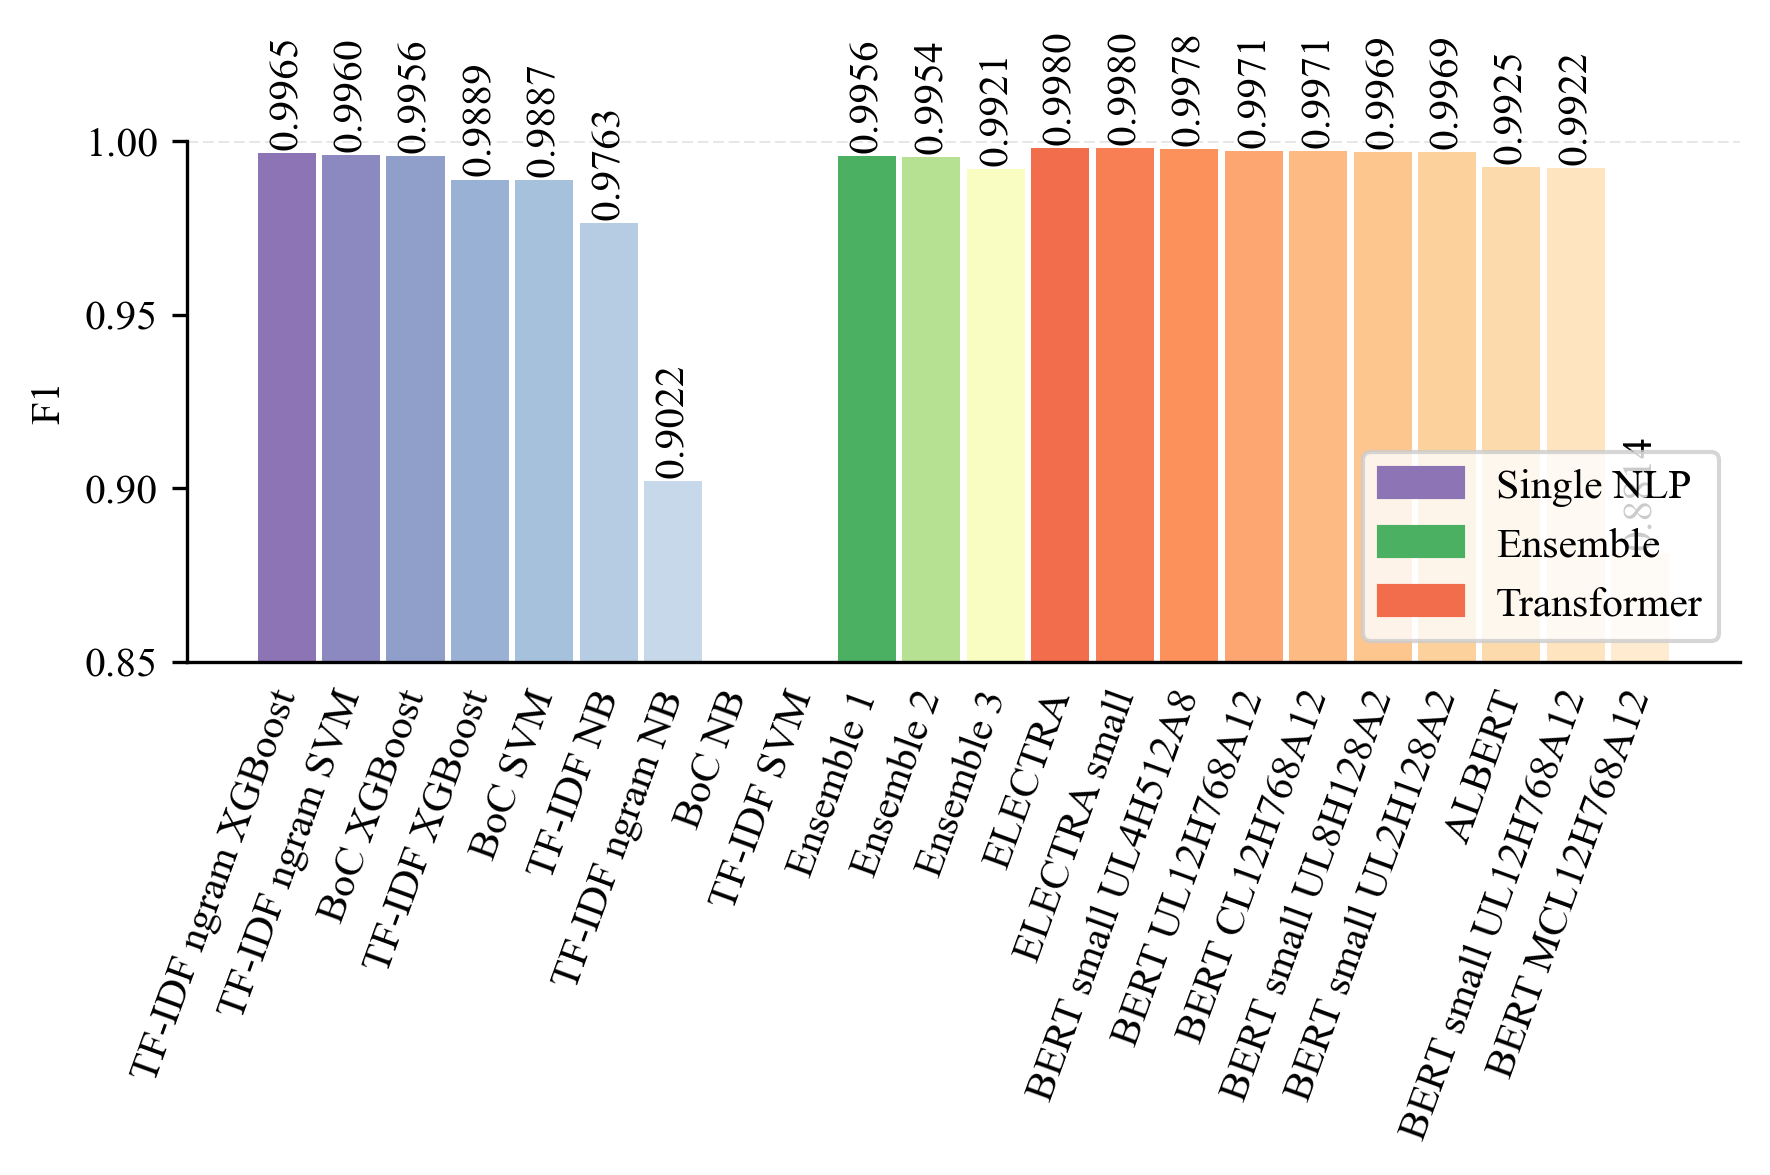

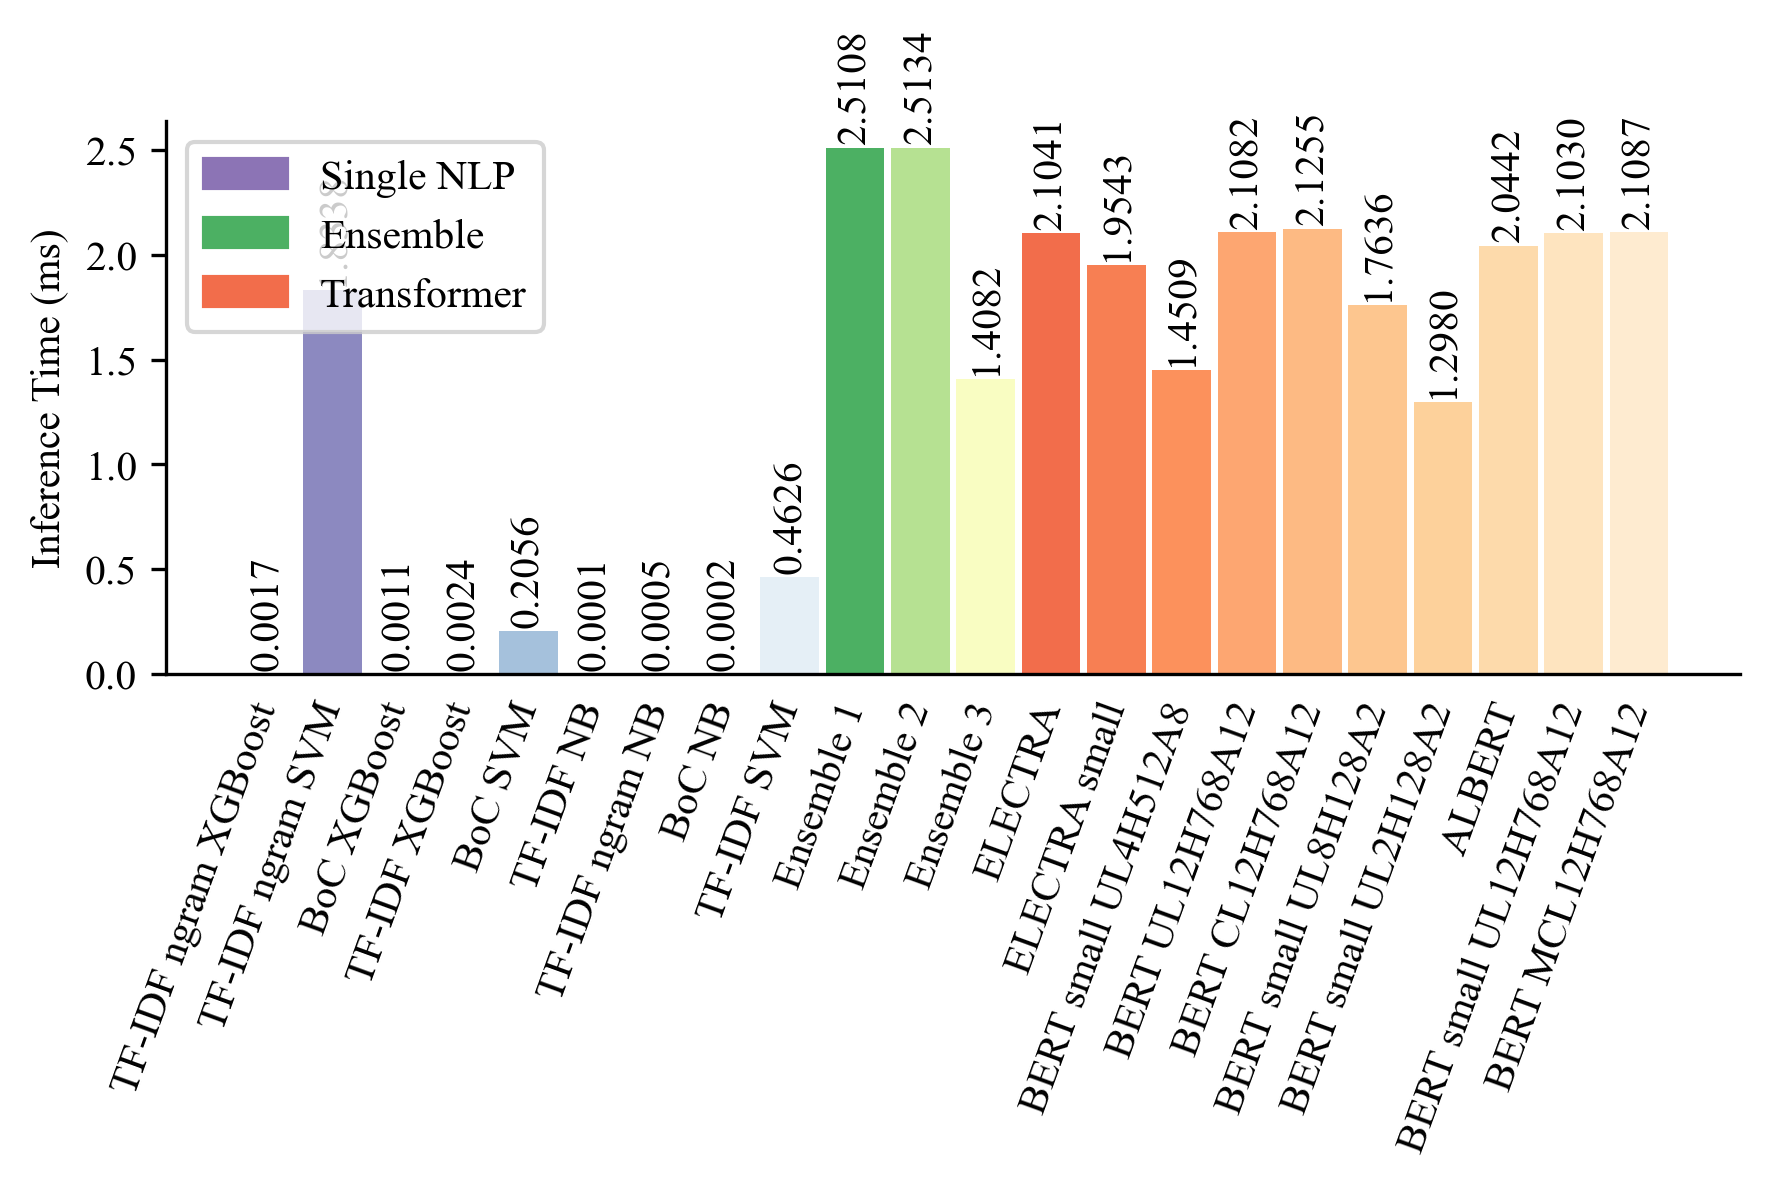

In [110]:
# method_category = 'transformer'
# metrics = ['overall_accuracy', 'precision', 'recall', 'f1', 'training time',
#        'testing time', 'color']
import matplotlib.patches as mpatches
df_small = df.sort_values(['category','f1_score'],ascending=[True, False])
df_small = rename_table_labels(df_small)
#df_small = df.loc[methods[method_category], metrics]
#df_small = df_small.sort_values(['category','f1'],ascending=[True, False])

# legend
color_cat_1 = np.asarray(df_small[df_small['category']=='classic_ml'] 
                         .head(1)['color'].values[0][0], dtype=np.float32) 
color_cat_2 = np.asarray(df_small[df_small['category']=='ensemble'] 
                         .head(1)['color'].values[0][0], dtype=np.float32) 
color_cat_3 = np.asarray(df_small[df_small['category']=='transformer'] 
                         .head(1)['color'].values[0][0], dtype=np.float32) 
legend_cat_1 = mpatches.Patch(color=color_cat_1, label='Single NLP')
legend_cat_2 = mpatches.Patch(color=color_cat_2, label='Ensemble')
legend_cat_3 = mpatches.Patch(color=color_cat_3, label='Transformer')

# Figure
current_figure_name = 'all_f1_sorted_f1.png'
fig, ax = plt.subplots(figsize=(6, 4))
my_plot_bar(df_small,ax,'F1')
plt.axhline(1, linestyle='--', linewidth=0.7, color=[0.9,0.9,0.9], zorder=0)
ax.set(ylim=(0.85, 1))
ax.set_ylabel('F1')
ax.legend(handles=[legend_cat_1, legend_cat_2, legend_cat_3],  loc='lower right')

fig.tight_layout()
if SAVE_OUTPUTS:
    ax.get_figure().savefig(figure_folder / current_figure_name)
###############################
current_figure_name = 'all_f1_sorted_inference_time.png'
fig, ax = plt.subplots(figsize=(6, 4))
my_plot_bar(df_small,ax,'Inference Time (ms)')
ax.set_ylabel('Inference Time (ms)')
ax.legend(handles=[legend_cat_1, legend_cat_2, legend_cat_3],  loc='upper left')
fig.tight_layout()
if SAVE_OUTPUTS:
    ax.get_figure().savefig(figure_folder / current_figure_name)

In [111]:
def process_style_to_my_latex_format(df_latex):
    # returns style object
    s = df_latex.reset_index().style.hide_index()
    s = s.format(precision=4, escape="latex")
    return s

### Single NLP (F1 vs Inference)

In [112]:
# Table: Single NLP
table_name = "single"
caption="Accuracy and inference speed of single NLP methods."
out_file_name = (table_folder / table_name).with_suffix('.tex') 
method_cat = 'classic_ml'
metrics = ['accuracy', 'precision', 'recall', 'f1_score', 'train_time',
       'pred_time', 'color', 'category', 'Method']

df_small = df.loc[df['category']==method_cat,metrics]

df_small = rename_table_labels(df_small)
df_small.set_index('Method', inplace=True)
#print(df_small)

s = process_style_to_my_latex_format(df_small.drop(['color', 'category'], axis=1 ))

s = s.highlight_max(props='textbf:--rwrap;', subset=s.columns[1:-2])
s = s.highlight_min(props='textbf:--rwrap;', subset=s.columns[-2:])

if SAVE_OUTPUTS:
    s.to_latex(buf=out_file_name,
       column_format="lrrrrrr", position="htbp", position_float="centering",
       hrules=True, label=f"tab:{table_name}", caption=caption)

print(s.to_latex(
    column_format="lrrrrrr", position="ht", position_float="centering",
    hrules=True, label=f"table:{table_name}", caption=caption)
)
#df.loc[:,"training time"] / df.loc[:,"train size"]
#(df.loc[:,["training time", "testing time"]]*1000).div(df.loc[:,["train size", "test size"]])

\begin{table}[ht]
\centering
\caption{Accuracy and inference speed of single NLP methods.}
\label{table:single}
\begin{tabular}{lrrrrrr}
\toprule
{Method} & {Accuracy} & {Precision} & {Recall} & {F1} & {Training Time (ms)} & {Inference Time (ms)} \\
\midrule
TF-IDF XGBoost & 0.9918 & 0.9969 & 0.9811 & 0.9889 & 0.0490 & 0.0024 \\
TF-IDF NB & 0.9824 & 0.9758 & 0.9767 & 0.9763 & \textbf{0.0002} & \textbf{0.0001} \\
TF-IDF SVM & 0.8107 & 0.6691 & 0.9696 & 0.7918 & 1.8855 & 0.4626 \\
TF-IDF ngram XGBoost & \textbf{0.9974} & \textbf{0.9996} & \textbf{0.9934} & \textbf{0.9965} & 0.3267 & 0.0017 \\
TF-IDF ngram NB & 0.9208 & 0.8328 & 0.9842 & 0.9022 & 0.0007 & 0.0005 \\
TF-IDF ngram SVM & 0.9971 & 0.9996 & 0.9925 & 0.9960 & 5.1707 & 1.8338 \\
BoC XGBoost & 0.9967 & 0.9996 & 0.9916 & 0.9956 & 0.1151 & 0.0011 \\
BoC NB & 0.8549 & 0.7585 & 0.8940 & 0.8207 & 0.0003 & 0.0002 \\
BoC SVM & 0.9917 & 0.9947 & 0.9828 & 0.9887 & 0.2374 & 0.2056 \\
\bottomrule
\end{tabular}
\end{table}



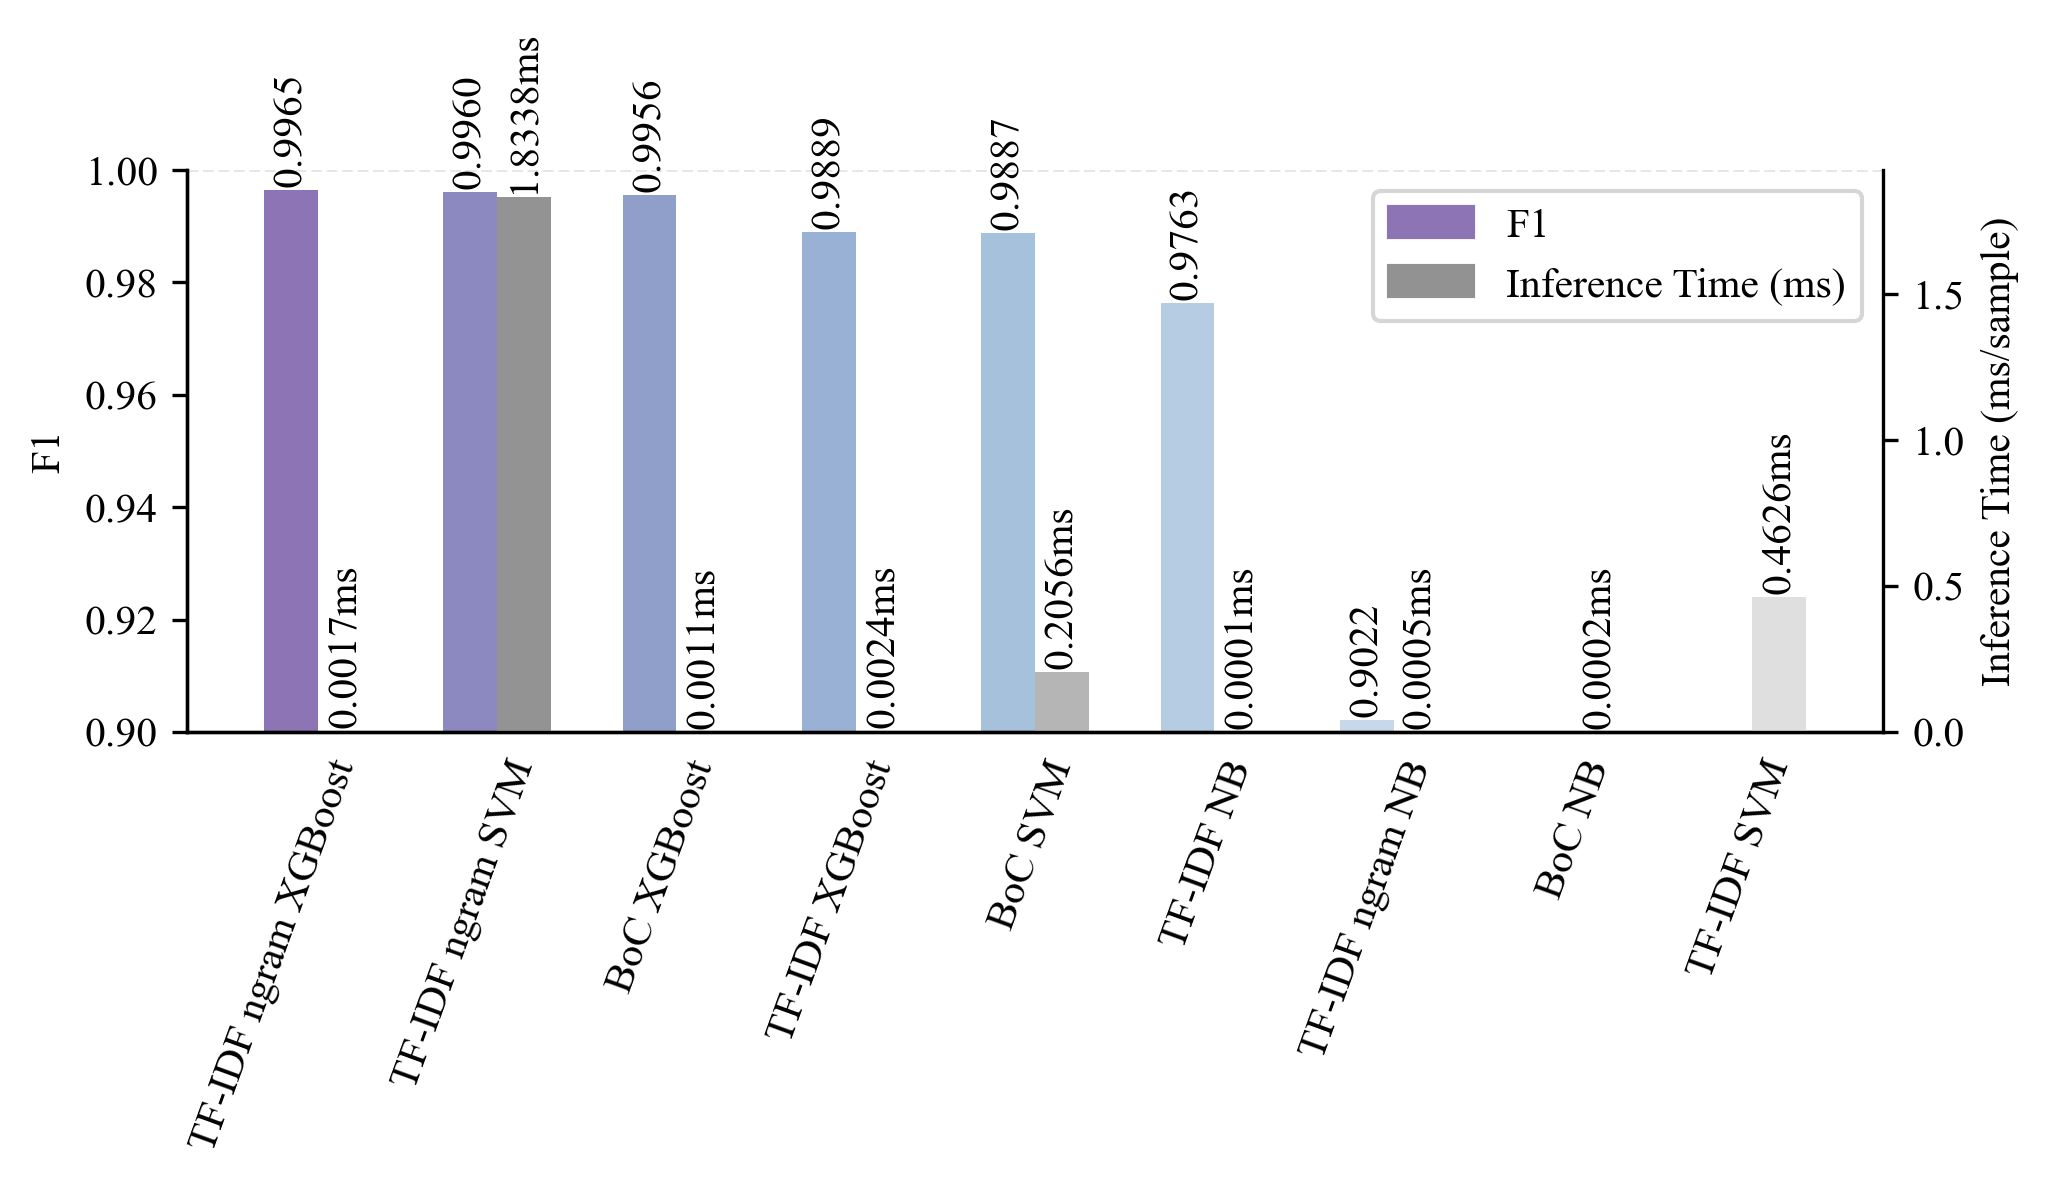

In [113]:
# Figure of Table Single NLP
current_figure_name = 'single_nlp_f1_vs_time.png'
fig, ax = plt.subplots( figsize=(7,4))

metric = ['F1', 'Inference Time (ms)']
df_small = df_small.sort_values(metric,ascending=False)

# legend
color_cat_1 = np.asarray(df_small[df_small['category']=='classic_ml'] 
                         .head(1)['color'].values[0][0], dtype=np.float32)
color_cat_1G = color_cat_1.copy()
color_cat_1G[0:3] = color_cat_1G[0:3].mean()

legend_cat_1 = mpatches.Patch(color=color_cat_1, label=metric[0])
legend_cat_1G = mpatches.Patch(color=color_cat_1G, label=metric[1])


df_small.reset_index(inplace=True)
_, ax2 = my_plot_twin_bar(df_small,ax,metric)
ax.axhline(1,  linestyle='--', linewidth=0.7, color=[0.9,0.9,0.9], zorder=0)
ax.set(ylim=(0.90, 1))
ax.set_ylabel('F1')

ax2.set_ylabel('Inference Time (ms/sample)')
# #ax.set(ylim=(0.95, 1))
ax2.legend(handles=[legend_cat_1, legend_cat_1G],  loc='upper right')

fig.tight_layout()
if SAVE_OUTPUTS:
    ax2.get_figure().savefig(figure_folder / current_figure_name)


### Table Ensemble NLP

In [114]:
# Table: Ensemble NLP
table_name = "ensemble"
caption="Accuracy and inference speed of ensemble NLP methods."
out_file_name = (table_folder / table_name).with_suffix('.tex') 
method_cat = 'ensemble'
metrics = ['accuracy', 'precision', 'recall', 'f1_score', 'train_time',
       'pred_time', 'color', 'category', 'Method']

df_small = df.loc[df['category']==method_cat,metrics]

df_small = rename_table_labels(df_small)
df_small.set_index('Method', inplace=True)
#print(df_small)

s = process_style_to_my_latex_format(df_small.drop(['color', 'category'], axis=1 ))


s = s.highlight_max(props='textbf:--rwrap;', subset=s.columns[1:-2])
s = s.highlight_min(props='textbf:--rwrap;', subset=s.columns[-2:])

if SAVE_OUTPUTS:
       s.to_latex(buf=out_file_name,
              column_format="lrrrrrr", position="htbp", position_float="centering",
              hrules=True, label=f"tab:{table_name}", caption=caption)

print(s.to_latex(
    column_format="lrrrrrr", position="ht", position_float="centering",
    hrules=True, label=f"table:{table_name}", caption=caption)
)

\begin{table}[ht]
\centering
\caption{Accuracy and inference speed of ensemble NLP methods.}
\label{table:ensemble}
\begin{tabular}{lrrrrrr}
\toprule
{Method} & {Accuracy} & {Precision} & {Recall} & {F1} & {Training Time (ms)} & {Inference Time (ms)} \\
\midrule
Ensemble 1 & \textbf{0.9967} & \textbf{1.0000} & \textbf{0.9912} & \textbf{0.9956} & 16.7710 & 2.5108 \\
Ensemble 2 & 0.9966 & \textbf{1.0000} & 0.9908 & 0.9954 & 16.7710 & 2.5134 \\
Ensemble 3 & 0.9941 & 0.9956 & 0.9886 & 0.9921 & \textbf{2.5102} & \textbf{1.4082} \\
\bottomrule
\end{tabular}
\end{table}



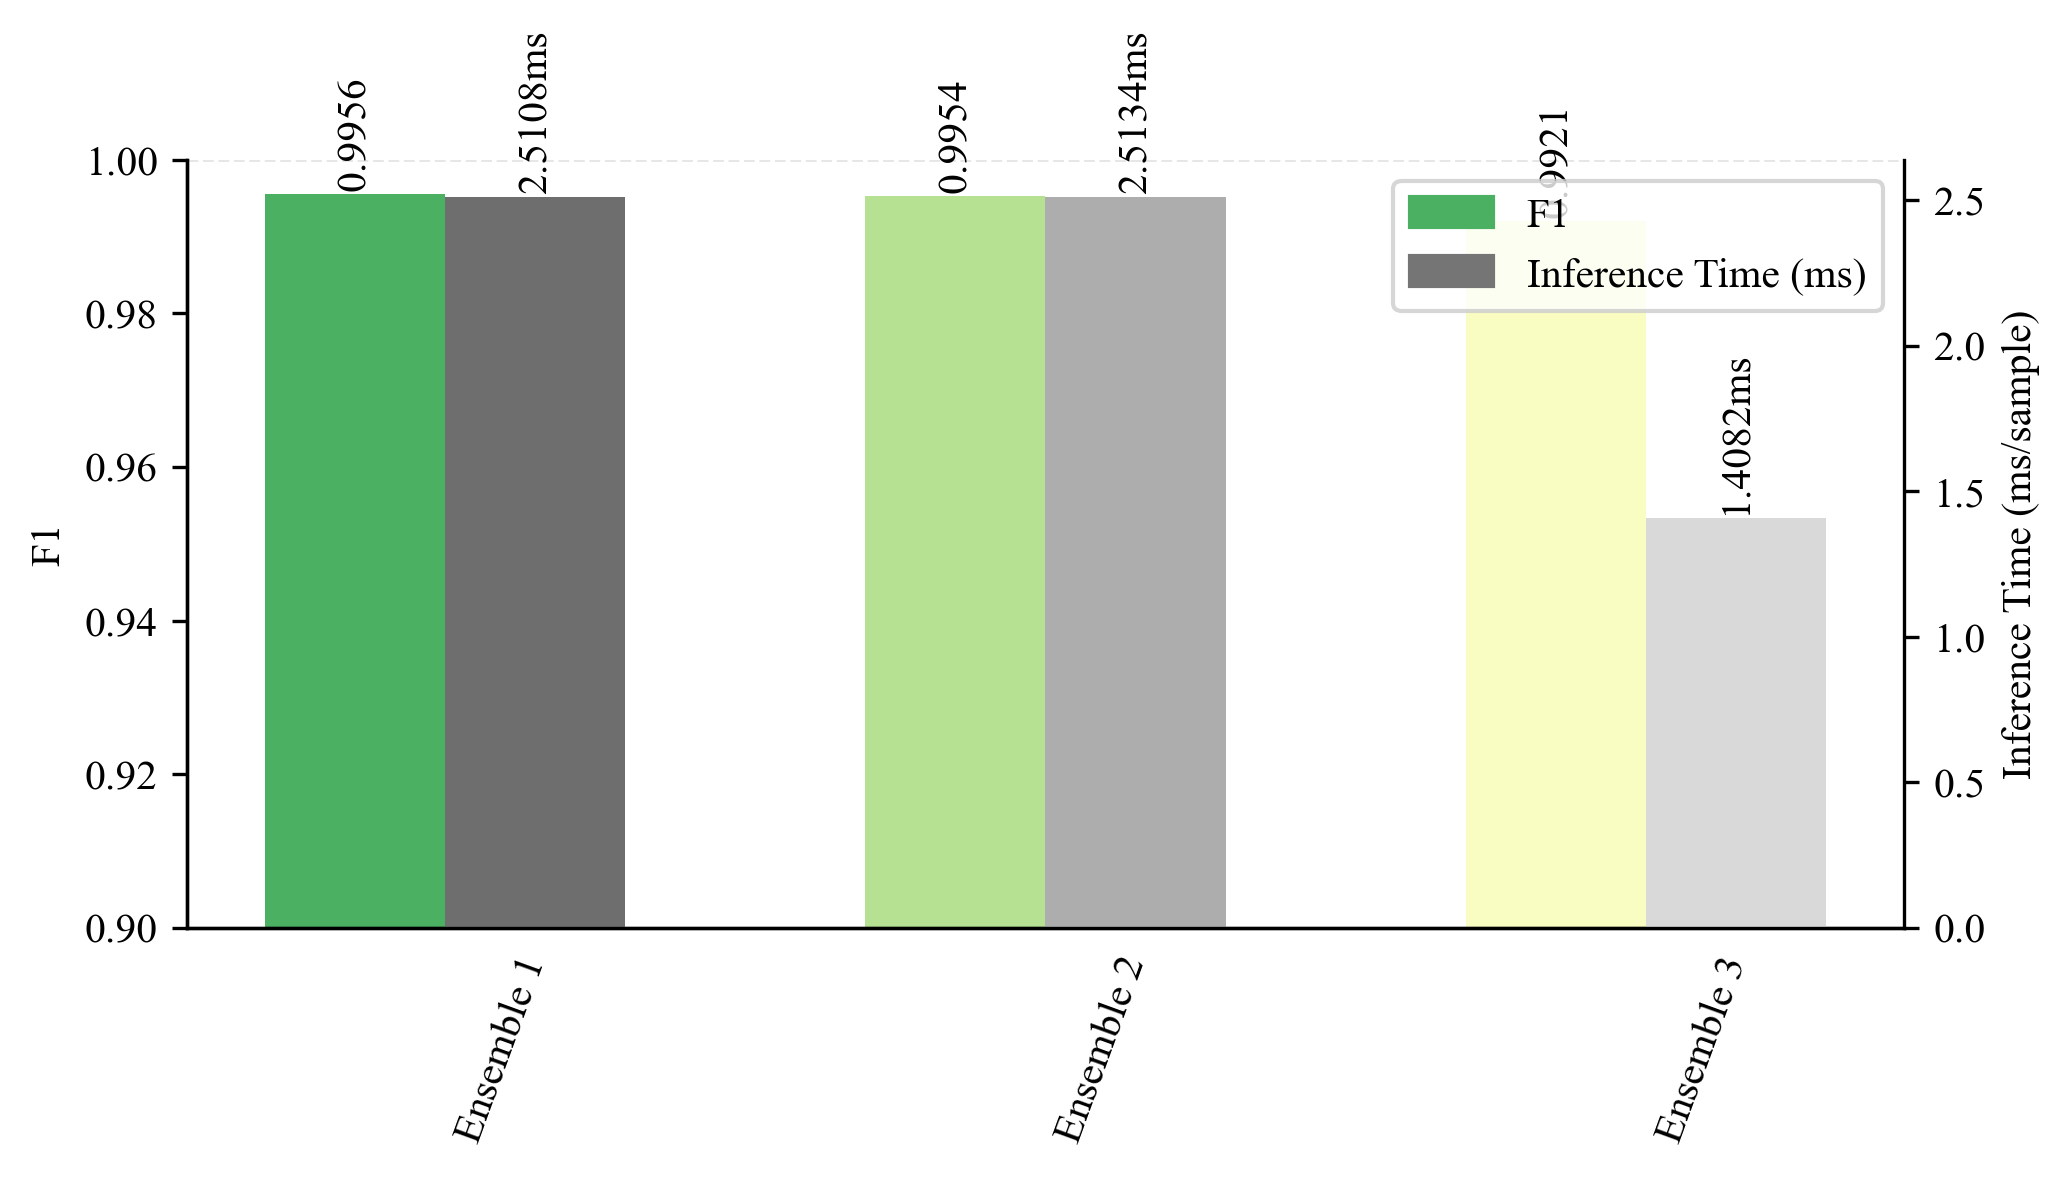

In [115]:
# Figure of Table Ensemble NLP
current_figure_name = 'ensemble_nlp_f1_vs_time.png'
fig, ax = plt.subplots( figsize=(7,4))

metric = ['F1', 'Inference Time (ms)']
df_small = df_small.sort_values(metric,ascending=False)

# legend
color_cat_1 = np.asarray(df_small[df_small['category']=='ensemble'] 
                         .head(1)['color'].values[0][0], dtype=np.float32)
color_cat_1G = color_cat_1.copy()
color_cat_1G[0:3] = color_cat_1G[0:3].mean()

legend_cat_1 = mpatches.Patch(color=color_cat_1, label=metric[0])
legend_cat_1G = mpatches.Patch(color=color_cat_1G, label=metric[1])


df_small.reset_index(inplace=True)
_, ax2 = my_plot_twin_bar(df_small,ax,metric)
ax.axhline(1,  linestyle='--', linewidth=0.7, color=[0.9,0.9,0.9], zorder=0)
ax.set(ylim=(0.90, 1))
ax.set_ylabel('F1')

ax2.set_ylabel('Inference Time (ms/sample)')
# #ax.set(ylim=(0.95, 1))
ax2.legend(handles=[legend_cat_1, legend_cat_1G],  loc='upper right')

fig.tight_layout()
if SAVE_OUTPUTS:
    ax2.get_figure().savefig(figure_folder / current_figure_name)


### Transformers

In [116]:
# Table: Transformer NLP
table_name = "transformer"
caption="Accuracy and inference speed of trasnformer NLP methods."
out_file_name = (table_folder / table_name).with_suffix('.tex') 
method_cat = 'transformer'
metrics = ['accuracy', 'precision', 'recall', 'f1_score', 'train_time',
       'pred_time', 'color', 'category', 'Method']

df_small = df.loc[df['category']==method_cat,metrics]

df_small = rename_table_labels(df_small)
df_small.set_index('Method', inplace=True)
#print(df_small)

s = process_style_to_my_latex_format(df_small.drop(['color', 'category'], axis=1 ))


s = s.highlight_max(props='textbf:--rwrap;', subset=s.columns[1:-2])
s = s.highlight_min(props='textbf:--rwrap;', subset=s.columns[-2:])

if SAVE_OUTPUTS:
       s.to_latex(buf=out_file_name,
              column_format="lrrrrrr", position="htbp", position_float="centering",
              hrules=True, label=f"tab:{table_name}", caption=caption)

print(s.to_latex(
    column_format="lrrrrrr", position="ht", position_float="centering",
    hrules=True, label=f"table:{table_name}", caption=caption)
)

\begin{table}[ht]
\centering
\caption{Accuracy and inference speed of trasnformer NLP methods.}
\label{table:transformer}
\begin{tabular}{lrrrrrr}
\toprule
{Method} & {Accuracy} & {Precision} & {Recall} & {F1} & {Training Time (ms)} & {Inference Time (ms)} \\
\midrule
BERT UL12H768A12 & 0.9979 & 0.9965 & \textbf{0.9978} & 0.9971 & 71.0688 & 2.1082 \\
BERT CL12H768A12 & 0.9979 & 0.9991 & 0.9952 & 0.9971 & 70.8124 & 2.1255 \\
BERT small UL2H128A2 & 0.9977 & \textbf{1.0000} & 0.9938 & 0.9969 & \textbf{23.9254} & \textbf{1.2980} \\
BERT small UL4H512A8 & 0.9984 & 0.9996 & 0.9960 & 0.9978 & 32.3589 & 1.4509 \\
BERT small UL8H128A2 & 0.9977 & 0.9982 & 0.9956 & 0.9969 & 44.8894 & 1.7636 \\
BERT small UL12H768A12 & 0.9943 & 0.9996 & 0.9850 & 0.9922 & 71.3447 & 2.1030 \\
BERT MCL12H768A12 & 0.9005 & 0.7907 & 0.9956 & 0.8814 & 80.7081 & 2.1087 \\
ALBERT & 0.9944 & 0.9996 & 0.9855 & 0.9925 & 67.2990 & 2.0442 \\
ELECTRA & \textbf{0.9985} & 0.9991 & 0.9969 & \textbf{0.9980} & 71.3494 & 2.1041 \\
EL

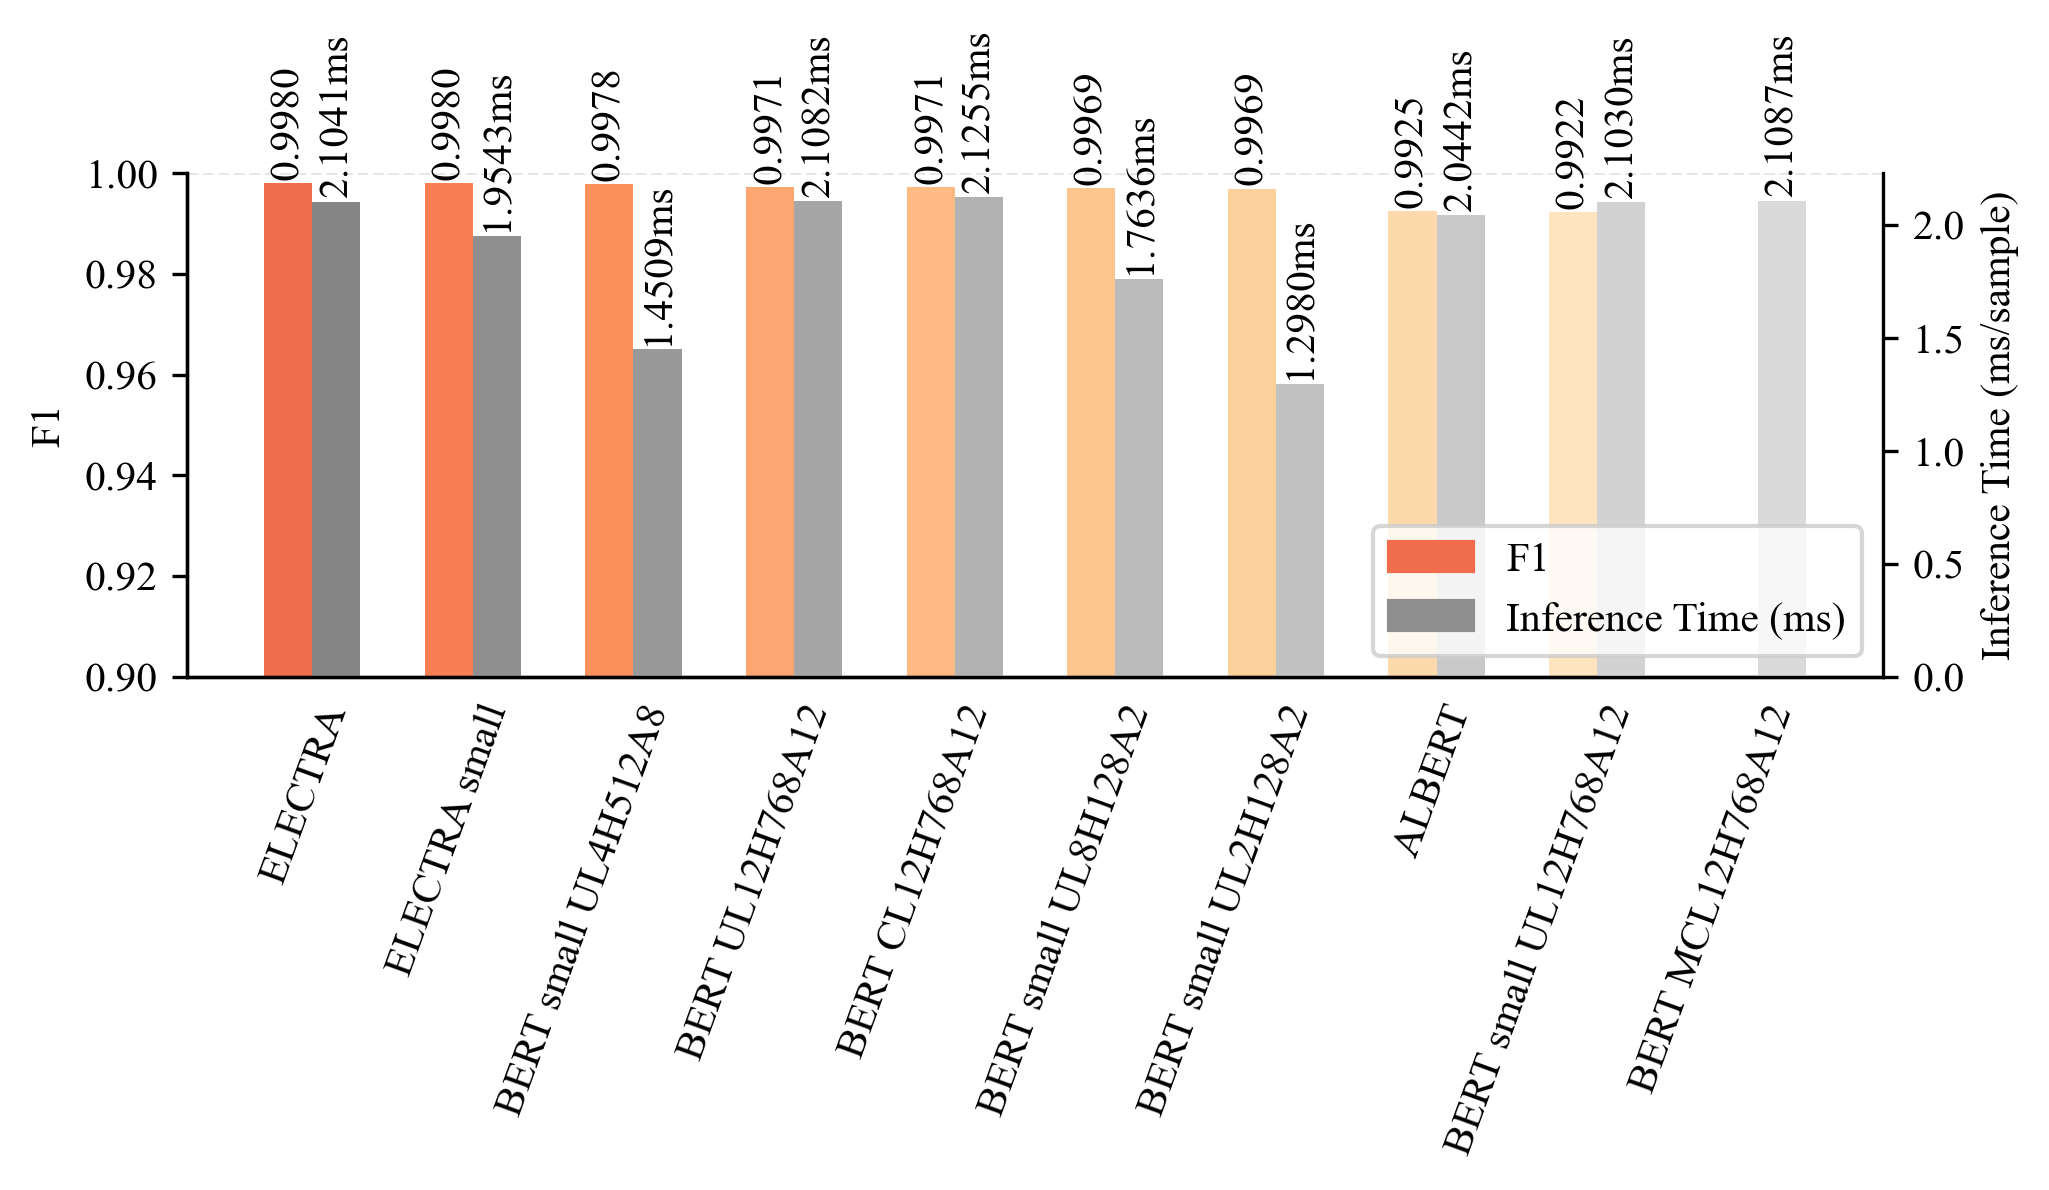

In [117]:
# Figure of Table Transformer NLP
current_figure_name = 'transformer_nlp_f1_vs_time.png'
fig, ax = plt.subplots( figsize=(7,4))

metric = ['F1', 'Inference Time (ms)']
df_small = df_small.sort_values(metric,ascending=False)

# legend
color_cat_1 = np.asarray(df_small[df_small['category']=='transformer'] 
                         .head(1)['color'].values[0][0], dtype=np.float32)
color_cat_1G = color_cat_1.copy()
color_cat_1G[0:3] = color_cat_1G[0:3].mean()

legend_cat_1 = mpatches.Patch(color=color_cat_1, label=metric[0])
legend_cat_1G = mpatches.Patch(color=color_cat_1G, label=metric[1])


df_small.reset_index(inplace=True)
_, ax2 = my_plot_twin_bar(df_small,ax,metric)
ax.axhline(1,  linestyle='--', linewidth=0.7, color=[0.9,0.9,0.9], zorder=0)
ax.set(ylim=(0.90, 1))
ax.set_ylabel('F1')


ax2.set_ylabel('Inference Time (ms/sample)')
# #ax.set(ylim=(0.95, 1))
ax2.legend(handles=[legend_cat_1, legend_cat_1G],  loc='lower right')
fig.tight_layout()
if SAVE_OUTPUTS:
    ax2.get_figure().savefig(figure_folder / current_figure_name)


### All methods FE score vs alpha

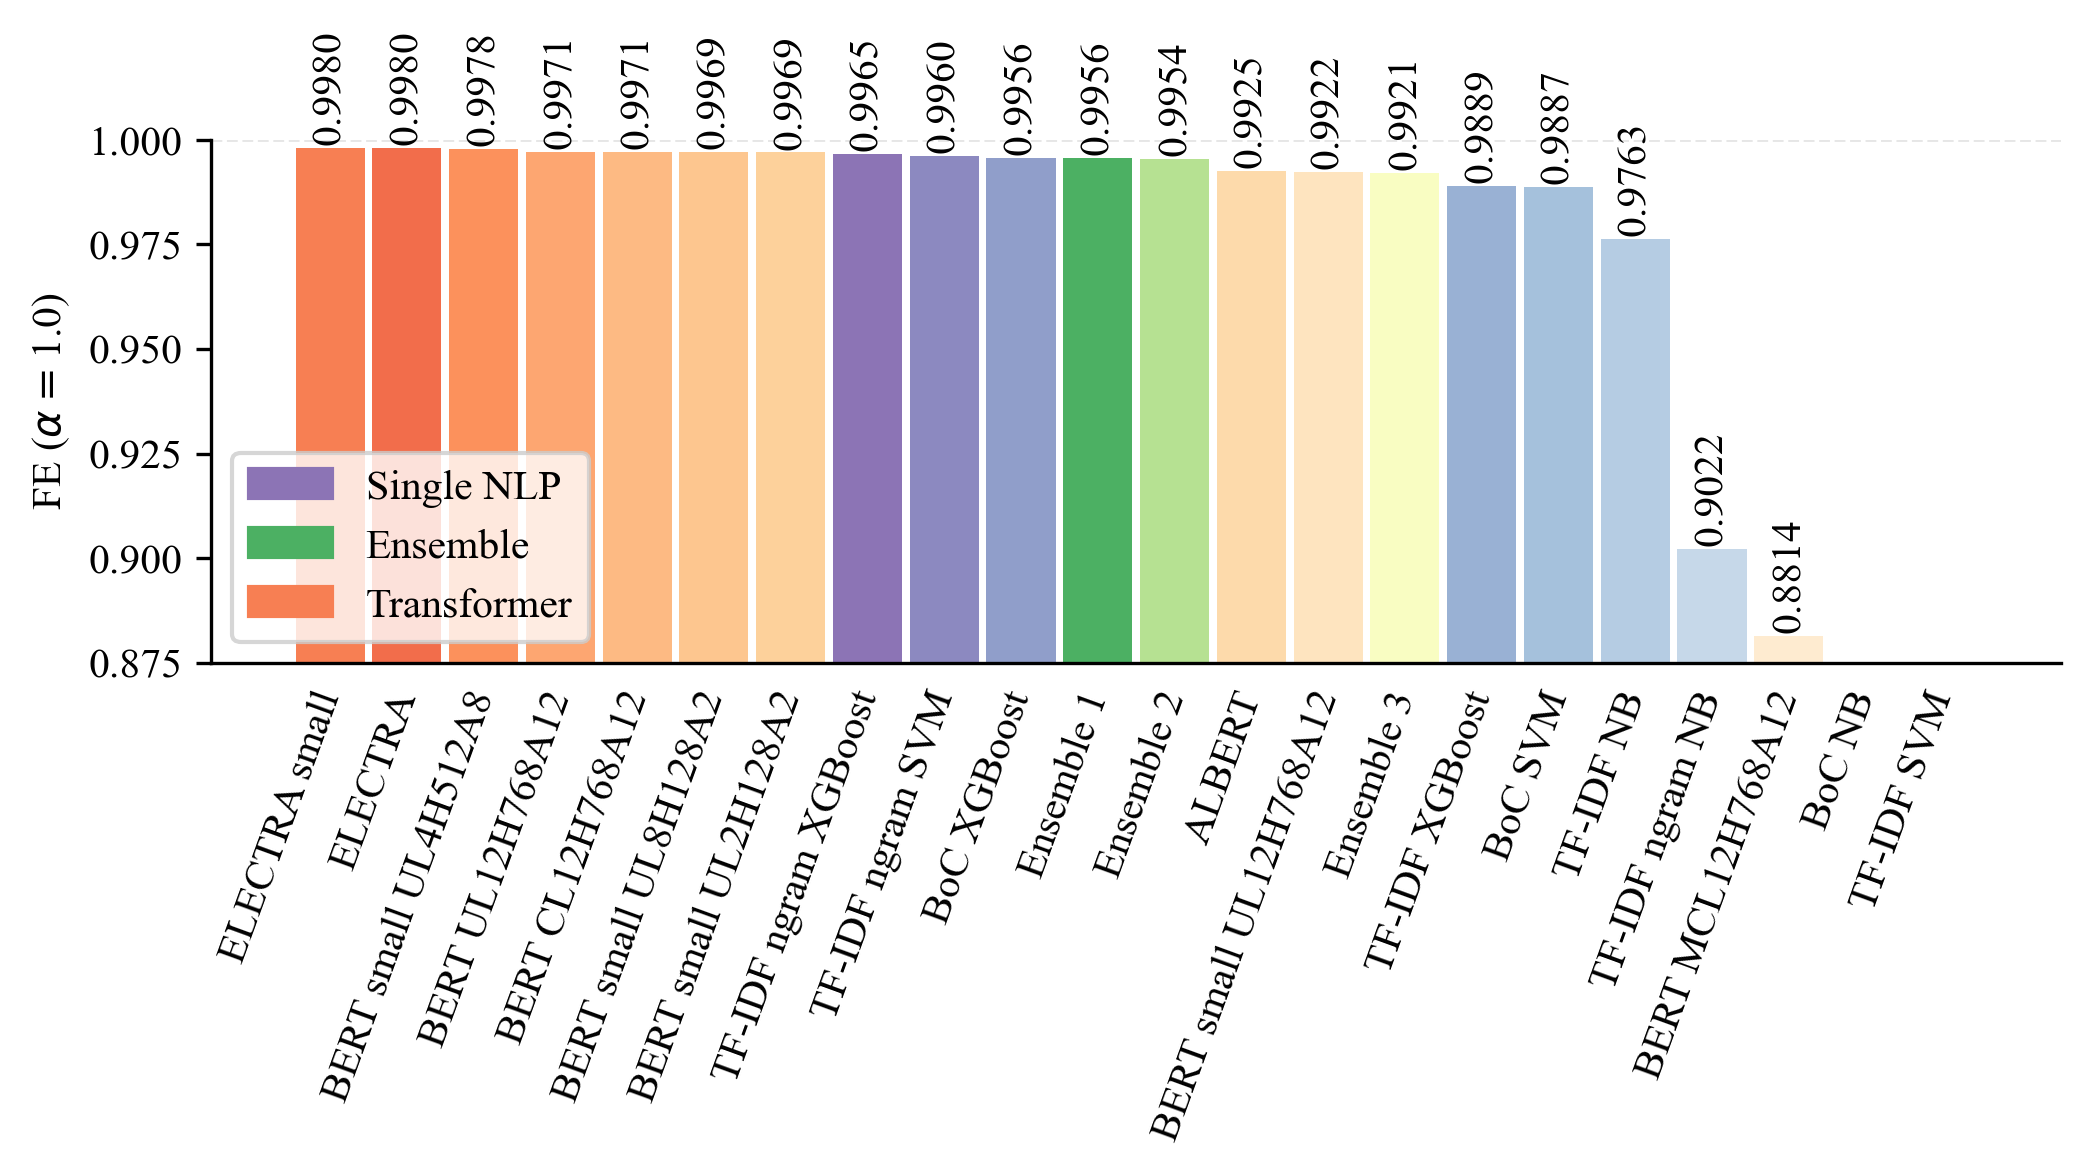

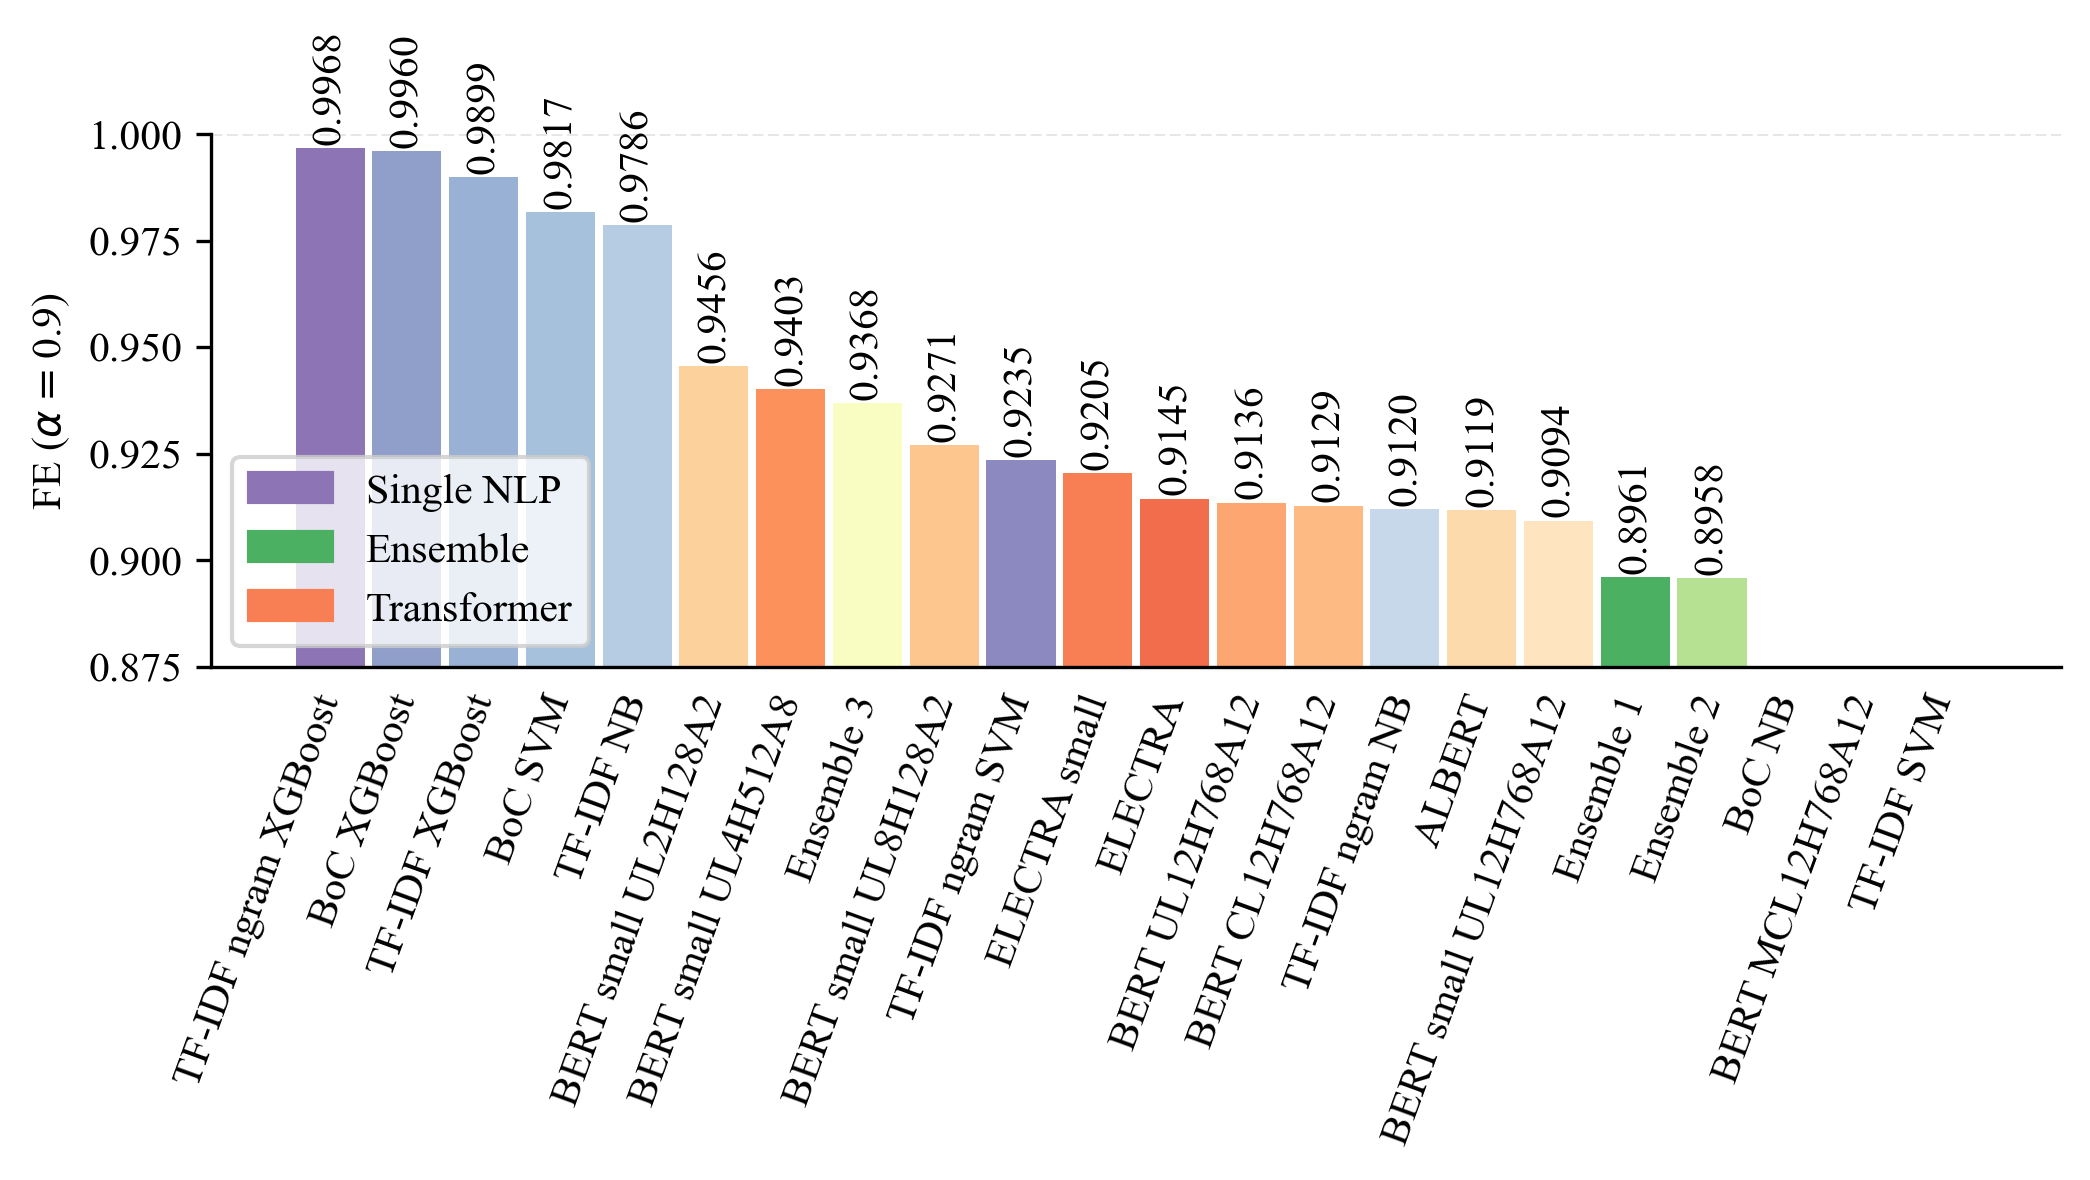

In [118]:
#ALL FE comparison for different alpha
from sklearn import preprocessing

current_figure_name = 'all_nlp_FE_alpha_100.png'

#df_small = df.sort_values(['category','f1'],ascending=[True, False])
df_small = df.sort_values('f1_score',ascending=False)

min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(1.0000 - df_small['pred_time'].to_numpy().reshape(-1, 1))
df_small['inference scaled'] = x_scaled

alpha = 1.0
#alpha=1.00 #emphasis on F1 rather than speed
df_small['FE_100'] = alpha*df_small['f1_score'] + (1-alpha)*df_small['inference scaled']
#print(df_small)
alpha = 0.9
df_small['FE_090'] = alpha*df_small['f1_score'] + (1-alpha)*df_small['inference scaled']

df_small = rename_table_labels(df_small)



# legend
color_cat_1 = np.asarray(df_small[df_small['category']=='classic_ml'] 
                         .head(1)['color'].values[0][0], dtype=np.float32) 
color_cat_2 = np.asarray(df_small[df_small['category']=='ensemble'] 
                         .head(1)['color'].values[0][0], dtype=np.float32) 
color_cat_3 = np.asarray(df_small[df_small['category']=='transformer'] 
                         .head(1)['color'].values[0][0], dtype=np.float32) 
legend_cat_1 = mpatches.Patch(color=color_cat_1, label='Single NLP')
legend_cat_2 = mpatches.Patch(color=color_cat_2, label='Ensemble')
legend_cat_3 = mpatches.Patch(color=color_cat_3, label='Transformer')

# Figure
fig, ax = plt.subplots(figsize=(7, 4))
df_small = df_small.sort_values('FE_100',ascending=False)

my_plot_bar(df_small,ax,'FE_100')
plt.axhline(1, linestyle='--', linewidth=0.7, color=[0.9,0.9,0.9], zorder=0)

ax.set_ylabel('FE'+ r' ($\alpha=$' + f'{1.0})')
#ax.set_xlabel(r'$\alpha=$' + f'{alpha}')
ax.set(ylim=(0.875, 1))
ax.legend(handles=[legend_cat_1, legend_cat_2, legend_cat_3],  loc='lower left')

fig.tight_layout()
if SAVE_OUTPUTS:
    ax.get_figure().savefig(figure_folder / current_figure_name)

#########################
current_figure_name = 'all_nlp_FE_alpha_090.png'
fig, ax = plt.subplots(figsize=(7, 4))
df_small = df_small.sort_values('FE_090',ascending=False)
my_plot_bar(df_small,ax,'FE_090')
plt.axhline(1, linestyle='--', linewidth=0.7, color=[0.9,0.9,0.9], zorder=0)
ax.set_ylabel('FE'+ r' ($\alpha=$' + f'{0.9})')
#ax.set_xlabel()
ax.set(ylim=(0.875, 1))
ax.legend(handles=[legend_cat_1, legend_cat_2, legend_cat_3],  loc='lower left')

fig.tight_layout()
if SAVE_OUTPUTS:
    ax.get_figure().savefig(figure_folder / current_figure_name)

# TODO
- 

# End